In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.stats import t

In [2]:
class hw_1():
    def __init__(self, X, y, model_type = 'lin lin'):
        
        self.model_type = model_type
        self.X_initial = X
        self.y_initial = y
        if model_type == 'lin lin':
            self.X = X
            self.y = y
        elif model_type == 'lin log':
            self.X = np.log(X)
        elif model_type == 'log lin':
            self.y = np.log(X)
        elif model_type == 'log log':
            self.X = np.log(X)
            self.y = np.log(y)
        else:
            print('Введите model_type из списка ["lin lin", "log log", "log lin", "lin log"]')
        
        self.y = y[np.argsort(self.X)]
        self.X = np.sort(self.X)
        self.ylabel = model_type.split(' ')[0]
        self.xlabel = model_type.split(' ')[1]
            
    def fit(self):

        self.X = sm.add_constant(self.X)
        model = sm.OLS(self.y, self.X)
        self.results = model.fit()
        print(self.results.summary())
        
        self.alpha = self.results.params[0]
        self.betta = self.results.params[1]
        
    def calc_intervals(self):
        # y variance
        y_var = self.results.cov_params()[0][0] + 2*self.X[:, 1]*self.results.cov_params()[1][0] \
        + self.X[:, 1]**2*self.results.cov_params()[1][1]
        # y доверительные интервалы
        df = self.X.shape[0] - self.X.shape[1] # степени свободы
        t_stat_bounds = t.interval(0.95, df = df)
        self.y_lower_bound = self.results.predict() + t_stat_bounds[0]*np.sqrt(y_var)
        self.y_upper_bound = self.results.predict() + t_stat_bounds[1]*np.sqrt(y_var)
        # Оценка дисперсии ошибок
        residuals = self.results.resid
        residuals_var = np.sum((residuals)**2)/(len(residuals)-2)
        print(residuals_var)
        # y предиктивные интервалы
        self.y_lower_bound_predictev = self.results.predict() + t_stat_bounds[0]*np.sqrt(residuals_var + y_var)
        self.y_upper_bound_predictev = self.results.predict() + t_stat_bounds[1]*np.sqrt(residuals_var + y_var)
    
    def print_intervals(self, x_axis_name, y_axis_name):
        
        plt.figure(figsize = (15, 15))
        _ = sns.lineplot(x = self.X[:, 1], y = self.y_lower_bound, color = 'red')
        _ = sns.lineplot(x = self.X[:, 1], y = self.y_upper_bound, color = 'red', label = '95% доверительный интервал')

        _ = sns.lineplot(x = self.X[:, 1], y = self.y_lower_bound_predictev, color = 'orange')
        _ = sns.lineplot(x = self.X[:, 1], y = self.y_upper_bound_predictev, color = 'orange', label = '95% предиктивный интервал')


        _ = sns.lineplot(x = self.X[:, 1], y = self.results.predict(), color = 'green', label = 'оцененная линия регрессии')
        _ = sns.scatterplot(x = self.X[:, 1], y = self.y)

        _ = plt.fill_between(self.X[:, 1], self.y_upper_bound, self.y_lower_bound, color = 'red', alpha = 0.5)
        _ = plt.fill_between(self.X[:, 1], self.y_upper_bound_predictev, self.y_lower_bound_predictev, color = 'orange', 
                             alpha = 0.5)

        if self.xlabel == 'log':
            _ = plt.xlabel('log(' + x_axis_name + ')')
        else:
            _ = plt.xlabel(x_axis_name)
        if self.ylabel == 'log':
            _ = plt.ylabel('log(' + y_axis_name + ')')
        else:
            _ = plt.ylabel(y_axis_name)
    
    def calc_elasticities(self, X):

        if self.model_type == 'lin lin':
            
            ME = self.betta
            E = self.betta * X/self.results.predict([1, X])
            
        elif self.model_type == 'log log':
            
            ME = self.betta * np.exp(self.results.predict([1, np.log(X)])) / X
            E =  self.betta
            
        elif self.model_type == 'log lin':
            
            ME = self.betta * np.exp(self.results.predict([1, X]))
            E = self.betta * X
            
        elif self.model_type == 'lin log':
            
            ME = self.betta/X
            E = self.betta/self.results.predict([1, np.log(X)])
        return(ME, E)

# Пункт A

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     12.41
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           0.000475
Time:                        13:58:51   Log-Likelihood:                -1531.4
No. Observations:                 408   AIC:                             3067.
Df Residuals:                     406   BIC:                             3075.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -69.3411     26.530     -2.614      0.0

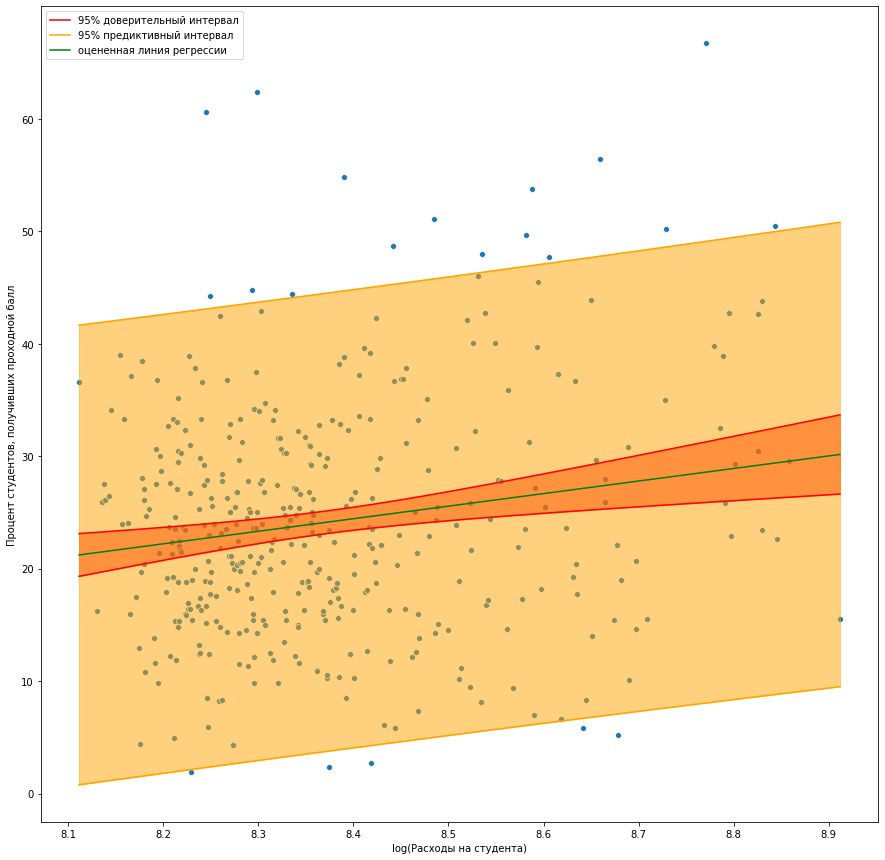

In [3]:
data_a = pd.read_stata('MEAP93.dta')

# Регрессоры
X = data_a['expend'].values
# Объясняемая переменная
y = data_a['math10'].values
# Инициализируем класс
point_a = hw_1(X, y, 'lin log')
# Обучаем модель
point_a.fit()
# Считаем доверительный и предиктивный интервал
point_a.calc_intervals()
# График интервалов, линия регрессии и скатерплот
point_a.print_intervals('Расходы на студента', 'Процент студентов, получивших проходной балл')
# Считаем эластичности

print('Среднее значение регрессора', np.mean(X))
print('Предсказанное значение при среднем регерссоре', point_a.results.predict([1, np.log(np.mean(X))]))
print('Предельный эффект и эластичность при среднем регрессоре', point_a.calc_elasticities(np.mean(X)))

print('Медианное значение регрессора', np.median(X))
print('Предсказанное значение при медианном регерссоре', point_a.results.predict([1, np.log(np.median(X))]))
print('Предельный эффект и эластичность при медианном регрессоре', point_a.calc_elasticities(np.median(X)))

# Пункт B

In [4]:
data_a = pd.read_stata('sav_inc.dta')

# Регрессоры
X = data_a['income'].values
# Объясняемая переменная
y = (data_a['income']-data_a['savings']).values

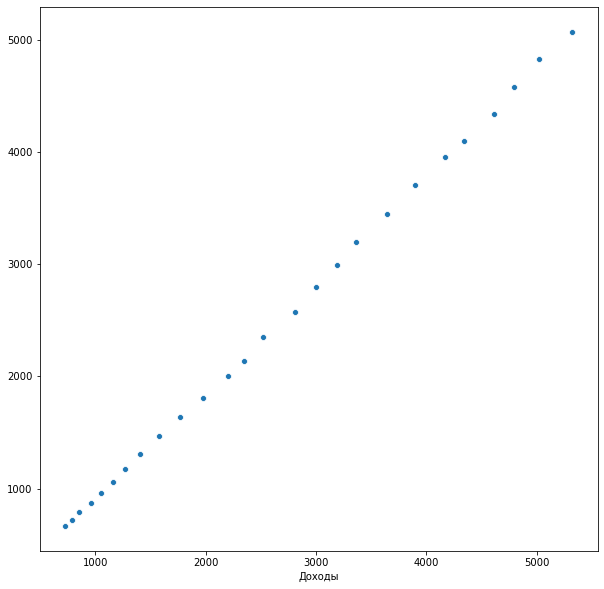

In [5]:
plt.figure(figsize = (10, 10))
_ = sns.scatterplot(X, y)
_ = plt.xlabel('Потребление')
_ = plt.xlabel('Доходы')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.160e+04
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           1.65e-41
Time:                        13:58:53   Log-Likelihood:                -125.24
No. Observations:                  26   AIC:                             254.5
Df Residuals:                      24   BIC:                             257.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -62.4227     12.761     -4.892      0.0

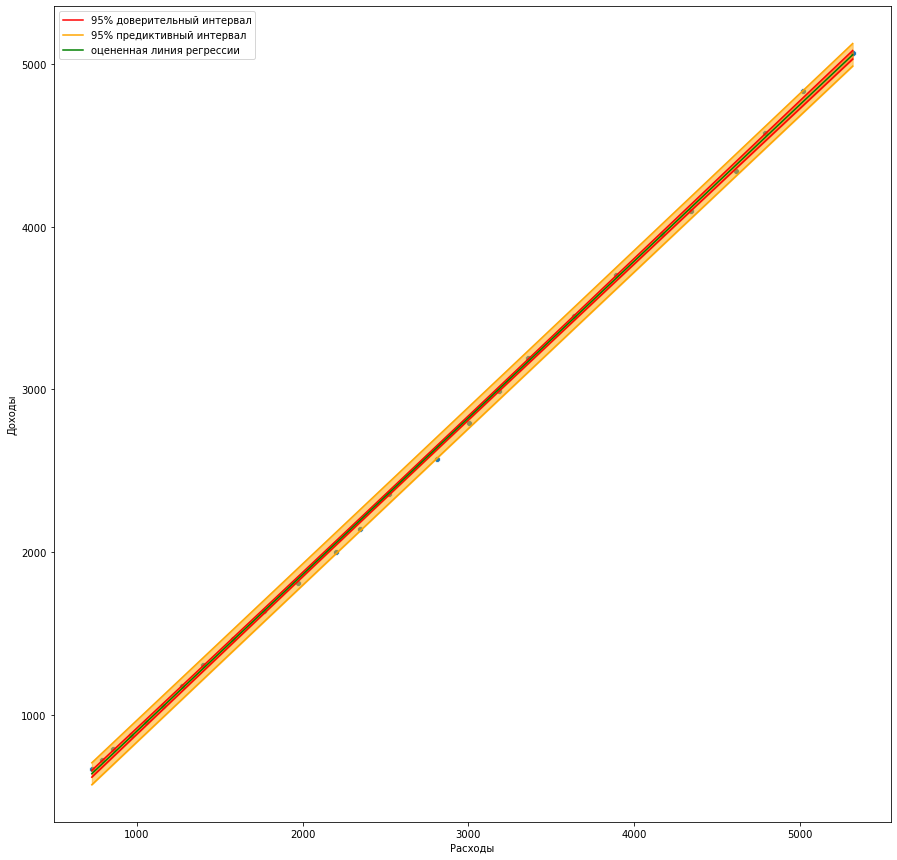

In [6]:
# Инициализируем класс
point_a = hw_1(X, y, 'lin lin')
# Обучаем модель
point_a.fit()
# Считаем доверительный и предиктивный интервал
point_a.calc_intervals()
# График интервалов, линия регрессии и скатерплот
point_a.print_intervals('Расходы', 'Доходы')
# Считаем эластичности

print('Среднее значение регрессора', np.mean(X))
print('Предсказанное значение при среднем регерссоре', point_a.results.predict([1, np.mean(X)]))
print('Предельный эффект и эластичность при среднем регрессоре', point_a.calc_elasticities(np.mean(X)))

print('Медианное значение регрессора', np.median(X))
print('Предсказанное значение при медианном регерссоре', point_a.results.predict([1, np.median(X)]))
print('Предельный эффект и эластичность при медианном регрессоре', point_a.calc_elasticities(np.median(X)))

# Пункт C

In [7]:
data_a = pd.read_stata('prfunc.dta')
data_a = data_a.drop('i', axis = 'columns')

In [8]:
data_a.corr()

,q,l,k
q,1.00000,0.982740,0.965160
l,0.98274,1.000000,0.992491
k,0.96516,0.992491,1.000000


In [9]:
data_a['log(q)'] = np.log(data_a['q'])
data_a['log(l)'] = np.log(data_a['l'])
data_a['log(k)'] = np.log(data_a['k'])

In [10]:
data_a[['log(q)', 'log(l)', 'log(k)']].corr()

,log(q),log(l),log(k)
log(q),1.000000,0.981894,0.982806
log(l),0.981894,1.000000,0.992118
log(k),0.982806,0.992118,1.000000


C:\Users\Sibmice\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     366.9
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           6.55e-11
Time:                        13:58:54   Log-Likelihood:                -71.554
No. Observations:                  15   AIC:                             147.1
Df Residuals:                      13   BIC:                             148.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1642.9401    212.165     -7.744      0.0

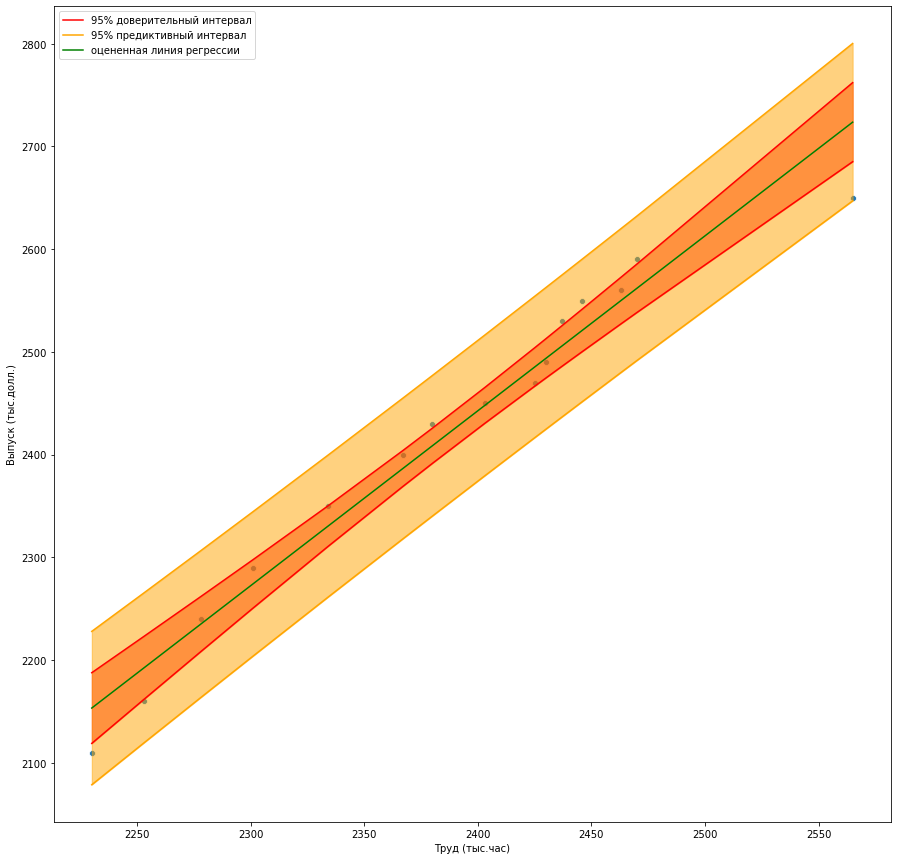

In [11]:
# Регрессоры
X = data_a['l'].values
# Объясняемая переменная
y = data_a['q'].values
# Инициализируем класс
point_a = hw_1(X, y, 'lin lin')
# Обучаем модель
point_a.fit()
# Считаем доверительный и предиктивный интервал
point_a.calc_intervals()
# График интервалов, линия регрессии и скатерплот
point_a.print_intervals('Труд (тыс.час)', 'Выпуск (тыс.долл.)')
# Считаем эластичности

print('Среднее значение регрессора', np.mean(X))
print('Предсказанное значение при среднем регерссоре', point_a.results.predict([1, np.mean(X)]))
print('Предельный эффект и эластичность при среднем регрессоре', point_a.calc_elasticities(np.mean(X)))

print('Медианное значение регрессора', np.median(X))
print('Предсказанное значение при медианном регерссоре', point_a.results.predict([1, np.median(X)]))
print('Предельный эффект и эластичность при медианном регрессоре', point_a.calc_elasticities(np.median(X)))

# Пункт D

In [35]:
data_a = pd.read_stata('foodexp.dta')

In [37]:
# Регрессоры
X = data_a['expend'].values
# Объясняемая переменная
y = data_a['fdho'].values

<AxesSubplot:>

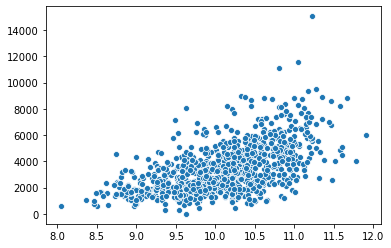

In [40]:
sns.scatterplot(np.log(X), y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     390.2
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           5.39e-72
Time:                        14:34:08   Log-Likelihood:                -7612.4
No. Observations:                 869   AIC:                         1.523e+04
Df Residuals:                     867   BIC:                         1.524e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.26e+04    816.773    -15.429      0.0

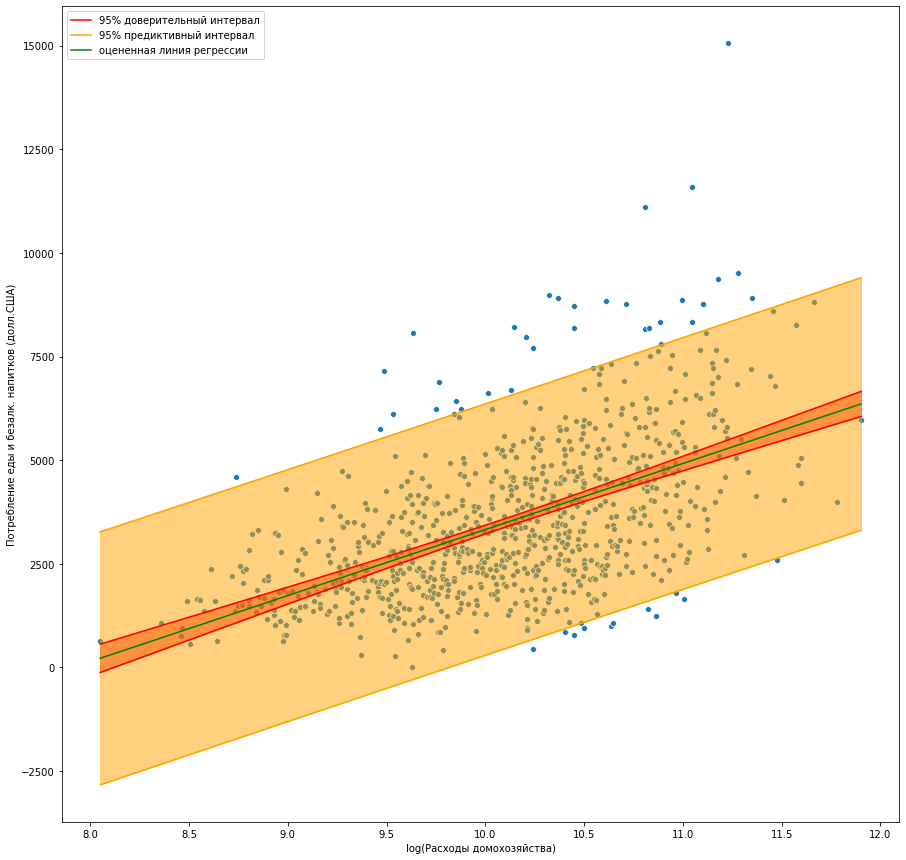

In [42]:
# Инициализируем класс
point_a = hw_1(X, y, 'lin log')
# Обучаем модель
point_a.fit()
# Считаем доверительный и предиктивный интервал
point_a.calc_intervals()
# График интервалов, линия регрессии и скатерплот
point_a.print_intervals('Расходы домохозяйства', 'Потребление еды и безалк. напитков (долл.США)')
# Считаем эластичности

print('Среднее значение регрессора', np.mean(X))
print('Предсказанное значение при среднем регерссоре', point_a.results.predict([1, np.log(np.mean(X))]))
print('Предельный эффект и эластичность при среднем регрессоре', point_a.calc_elasticities(np.mean(X)))

print('Медианное значение регрессора', np.median(X))
print('Предсказанное значение при медианном регерссоре', point_a.results.predict([1, np.log(np.median(X))]))
print('Предельный эффект и эластичность при медианном регрессоре', point_a.calc_elasticities(np.median(X)))

# Пункт C

In [43]:
data_a = pd.read_stata('beauty.dta')

In [45]:
data_a['course_eval'].isnull().sum()

0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     17.08
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           4.25e-05
Time:                        15:08:41   Log-Likelihood:                -375.32
No. Observations:                 463   AIC:                             754.6
Df Residuals:                     461   BIC:                             762.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9983      0.025    157.727      0.0

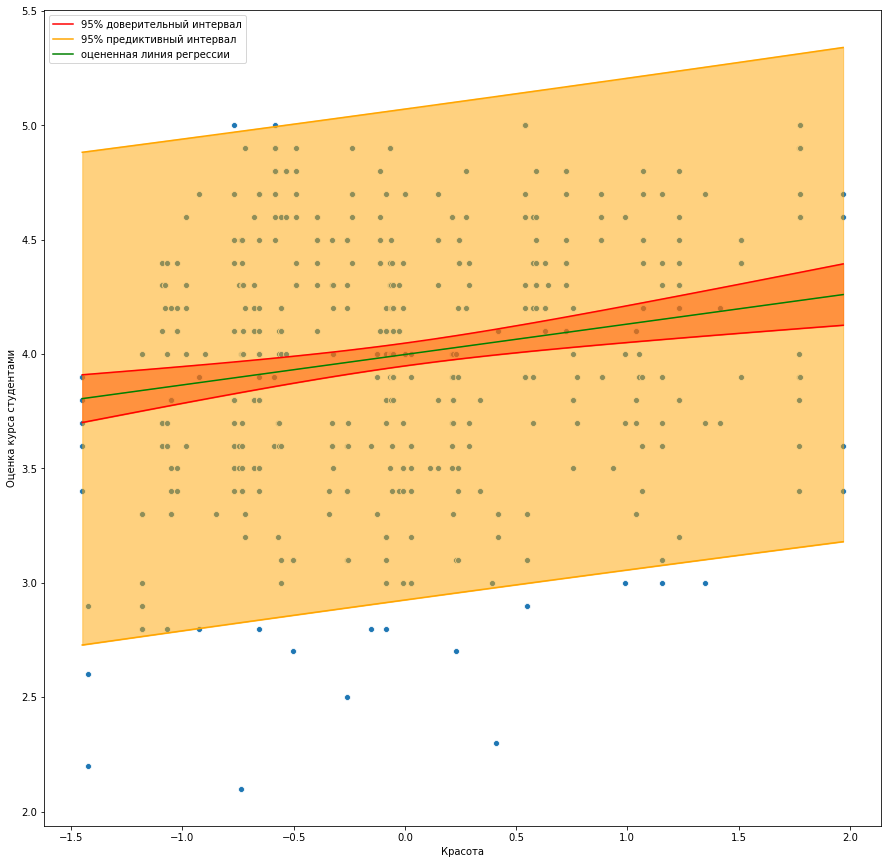

In [48]:
# Регрессоры
X = data_a['beauty'].values
# Объясняемая переменная
y = data_a['course_eval'].values
# Инициализируем класс
point_a = hw_1(X, y, 'lin lin')
# Обучаем модель
point_a.fit()
# Считаем доверительный и предиктивный интервал
point_a.calc_intervals()
# График интервалов, линия регрессии и скатерплот
point_a.print_intervals('Красота', 'Оценка курса студентами')
# Считаем эластичности

print('Среднее значение регрессора', np.mean(X))
print('Предсказанное значение при среднем регерссоре', point_a.results.predict([1, np.mean(X)]))
print('Предельный эффект и эластичность при среднем регрессоре', point_a.calc_elasticities(np.mean(X)))

print('Медианное значение регрессора', np.median(X))
print('Предсказанное значение при медианном регерссоре', point_a.results.predict([1, np.median(X)]))
print('Предельный эффект и эластичность при медианном регрессоре', point_a.calc_elasticities(np.median(X)))